In [8]:
import pandas as pd
import openpyxl # openpyxl은 Pandas의 Excel 엔진으로 사용됩니다.
import time
import os
import random
import gc # 가비지 컬렉션 모듈

# --- 1. 대용량 Excel 파일 생성 (Pandas 사용) ---
# 주의: Excel 파일 생성은 CSV보다 느립니다. 테스트 크기를 적절히 조절하세요.
excel_file_name = "large_data_excel_compare.xlsx" # 파일명 변경하여 기존 large_data.xlsx와 구분
num_excel_rows = 1_000_000 # 비교적 큰 규모의 Excel 파일 (수백만 줄은 생성 및 읽기 매우 오래 걸림)
num_excel_columns = 10
excel_headers = [f"col_{i}" for i in range(num_excel_columns)]

if not os.path.exists(excel_file_name):
    print(f"'{excel_file_name}' 파일 생성 중... (오래 걸릴 수 있습니다)")
    start_gen = time.time()
    # 대용량 DataFrame 생성
    data_to_write = {
        f"col_{j}": [f"value_{i}_{j}" if j % 2 == 0 else random.randint(1, 1000000)
                     for i in range(num_excel_rows)]
        for j in range(num_excel_columns)
    }
    df_gen = pd.DataFrame(data_to_write)
    
    # Excel 파일로 저장 (engine='openpyxl' 명시)
    df_gen.to_excel(excel_file_name, index=False, engine='openpyxl')
    
    end_gen = time.time()
    print(f"'{excel_file_name}' 파일 생성 완료. 소요 시간: {end_gen - start_gen:.2f} 초")
    del df_gen # 파일 생성 후 DataFrame 객체 메모리에서 삭제
    gc.collect() # 가비지 컬렉션
else:
    print(f"'{excel_file_name}' 파일이 이미 존재합니다. 다시 생성하지 않습니다.")

'large_data_excel_compare.xlsx' 파일 생성 중... (오래 걸릴 수 있습니다)
'large_data_excel_compare.xlsx' 파일 생성 완료. 소요 시간: 100.96 초


# 파일 크기

In [9]:
import os

def get_file_size_mb_gb(file_path):
    """
    주어진 파일 경로의 파일 크기를 바이트, 킬로바이트(KB), 메가바이트(MB), 기가바이트(GB) 단위로 반환합니다.

    Args:
        file_path (str): 크기를 확인할 파일의 경로.

    Returns:
        tuple: (bytes, kb, mb, gb) 형식의 튜플.
               파일이 없거나 접근할 수 없으면 (None, None, None, None)을 반환합니다.
    """
    if not os.path.exists(file_path):
        # print(f"오류: '{file_path}' 파일이 존재하지 않습니다.") # 메시지 중복 방지
        return None, None, None, None
    
    if not os.path.isfile(file_path):
        # print(f"오류: '{file_path}'는 파일이 아니라 디렉토리입니다.") # 메시지 중복 방지
        return None, None, None, None

    try:
        size_in_bytes = os.path.getsize(file_path)
        size_in_kb = size_in_bytes / 1024
        size_in_mb = size_in_kb / 1024
        size_in_gb = size_in_mb / 1024
        return size_in_bytes, size_in_kb, size_in_mb, size_in_gb
    except Exception as e:
        # print(f"파일 크기를 확인하는 중 오류 발생: {e}") # 메시지 중복 방지
        return None, None, None, None

def print_file_size(file_path):
    """
    파일 크기를 사람이 읽기 쉬운 형식(MB 또는 GB)으로 출력합니다.
    """
    size_bytes, size_kb, size_mb, size_gb = get_file_size_mb_gb(file_path)

    if size_bytes is not None:
        print(f"\n--- 파일 크기 정보: '{file_path}' ---")
        print(f"바이트 (Bytes): {size_bytes} B")
        print(f"킬로바이트 (KB): {size_kb:.2f} KB")
        print(f"메가바이트 (MB): {size_mb:.2f} MB")
        print(f"기가바이트 (GB): {size_gb:.2f} GB")

        if size_gb >= 1:
            print(f"-> 파일 크기: {size_gb:.2f} GB")
        elif size_mb >= 1:
            print(f"-> 파일 크기: {size_mb:.2f} MB")
        elif size_kb >= 1:
            print(f"-> 파일 크기: {size_kb:.2f} KB")
        else:
            print(f"-> 파일 크기: {size_bytes} B")
    else:
        print(f"'{file_path}' 파일이 존재하지 않거나 접근할 수 없습니다.")
    print("---------------------------------------")

# 현재 확인하고자 하는 Excel 파일명
excel_file_name = "large_data_excel_compare.xlsx"

# 파일 크기 확인 및 출력
print_file_size(excel_file_name)


--- 파일 크기 정보: 'large_data_excel_compare.xlsx' ---
바이트 (Bytes): 59715467 B
킬로바이트 (KB): 58315.89 KB
메가바이트 (MB): 56.95 MB
기가바이트 (GB): 0.06 GB
-> 파일 크기: 56.95 MB
---------------------------------------


# Excel 추출 방식별 함수 정의

In [10]:
# --- 2. Excel 추출 방식별 함수 정의 (두 가지 방식만 포함) ---

# (2-1) Pandas 기본 read_excel
def read_excel_pandas_default(file_path):
    """Pandas의 read_excel 기본 모드로 Excel 파일 읽기"""
    # engine='openpyxl'은 .xlsx 파일을 다룰 때 명시적으로 권장됨
    df = pd.read_excel(file_path, engine='openpyxl')
    return df

# (2-2) Pandas read_excel + openpyxl read_only 모드 (메모리 최적화)
def read_excel_pandas_read_only(file_path):
    """
    Pandas를 통해 openpyxl의 read_only 모드를 사용하여 Excel 파일 읽기.
    `engine_kwargs={'read_only': True}` 옵션은 openpyxl이 파일을 읽을 때
    쓰기 가능한 객체를 생성하지 않고 오직 읽기 목적으로만 데이터를 로드하도록 지시합니다.
    이는 메모리 사용량을 줄이는 데 도움이 될 수 있습니다.
    """
    df = pd.read_excel(file_path, engine='openpyxl', engine_kwargs={'read_only': True})
    return df

# 각 방식별 시간 측정 및 메모리 관리

In [11]:
# --- 3. 각 방식별 시간 측정 및 메모리 관리 ---
pandas_default_time = 0
pandas_read_only_time = 0

if os.path.exists(excel_file_name):
    # 🔸 (3-1) Pandas 기본 read_excel
    print("--- Pandas 기본 read_excel로 Excel 추출 시작 ---")
    start_time = time.time()
    df_pandas_default = read_excel_pandas_default(excel_file_name)
    end_time = time.time()
    pandas_default_time = end_time - start_time
    print(f"Pandas 기본 read_excel 완료. 총 {len(df_pandas_default)} 줄, 소요 시간: {pandas_default_time:.2f} 초")
    del df_pandas_default # 추출된 DataFrame 객체를 메모리에서 삭제
    gc.collect()          # 가비지 컬렉션 실행

    # 🔸 (3-2) Pandas read_excel + openpyxl read_only 모드
    print("\n--- Pandas (read_only 모드)로 Excel 추출 시작 ---")
    start_time = time.time()
    df_pandas_read_only = read_excel_pandas_read_only(excel_file_name)
    end_time = time.time()
    pandas_read_only_time = end_time - start_time
    print(f"Pandas (read_only 모드) 추출 완료. 총 {len(df_pandas_read_only)} 줄, 소요 시간: {pandas_read_only_time:.2f} 초")
    del df_pandas_read_only # 추출된 DataFrame 객체를 메모리에서 삭제
    gc.collect()            # 가비지 컬렉션 실행

else:
    print(f"'{excel_file_name}' 파일이 없습니다. 먼저 파일을 생성해주세요.")

--- Pandas 기본 read_excel로 Excel 추출 시작 ---
Pandas 기본 read_excel 완료. 총 1000000 줄, 소요 시간: 75.24 초

--- Pandas (read_only 모드)로 Excel 추출 시작 ---
Pandas (read_only 모드) 추출 완료. 총 1000000 줄, 소요 시간: 73.50 초


# Excel 추출 속도 비교 시각화

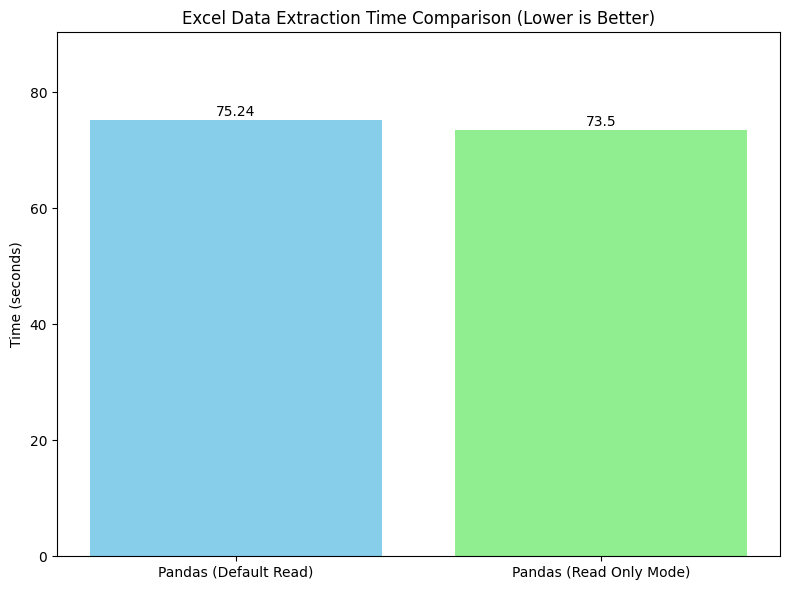

In [12]:
# --- 4. Excel 추출 속도 비교 시각화 ---
import matplotlib.pyplot as plt
import numpy as np

labels_excel = [
    'Pandas (Default Read)', 
    'Pandas (Read Only Mode)'
]
times_excel = [
    pandas_default_time, 
    pandas_read_only_time
]

# 모든 시간이 측정되었을 때만 그래프 표시
if all(time_val > 0 for time_val in times_excel):
    fig, ax = plt.subplots(figsize=(8, 6)) # 그래프 크기 조정
    bars = ax.bar(labels_excel, times_excel, color=['skyblue', 'lightgreen'])
    
    ax.set_ylabel('Time (seconds)')
    ax.set_title('Excel Data Extraction Time Comparison (Lower is Better)')
    ax.set_ylim(0, max(times_excel) * 1.2)
    
    # 막대 위에 값 표시
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, round(yval, 2), ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
else:
    print("\nExcel 추출 시간 데이터가 완전하지 않아 그래프를 그릴 수 없습니다.")